In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import matplotlib as mpl

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *
from ar6_area_weighted_cont_global import *


In [3]:
path = './saved_data/'

def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

obs_all = load_xr_pickle(path + '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

obs_200runs_all = load_xr_pickle(path + '0.2.HadCRUT5.200runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

mod_all = load_xr_pickle(path + '0.4.Smoothed_His-ALL.25mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_sub_forcing = load_xr_pickle(path + '0.4.Smoothed_His-ANT.NAT.GHG.OA.10mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_all = xr.concat([mod_all,mod_sub_forcing],dim = 'forcing')

ln_mod_all = load_xr_pickle(path + '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

print_xarray_info(obs_all, obs_200runs_all, mod_all, ln_mod_all, mod_45_pseudo)


Array 1:
  Sizes: Frozen({'year': 175, 'region': 54})
  Coords: ['realization', 'year', 'region', 'abbrevs', 'names']

Array 2:
  Sizes: Frozen({'runs': 200, 'year': 175, 'region': 54})
  Coords: ['runs', 'year', 'region', 'abbrevs', 'names']

Array 3:
  Sizes: Frozen({'forcing': 5, 'model_name': 25, 'year': 176, 'region': 54})
  Coords: ['model_name', 'region', 'year', 'forcing', 'abbrevs', 'names']

Array 4:
  Sizes: Frozen({'model_run': 320, 'year': 251, 'region': 54})
  Coords: ['year', 'model_run', 'model_name', 'region', 'abbrevs', 'names']

Array 5:
  Sizes: Frozen({'model_run': 45, 'year': 176, 'region': 54})
  Coords: ['model_run', 'year', 'model_name', 'region', 'abbrevs', 'names']


In [6]:
from f_schemes import *

# -----------------------------------------
# Define time periods
# -----------------------------------------

ref_period = (1850, 1900)

warming_target_period1 = (2016, 2025)

# -----------------------------------------
# Define constraint schemes
# -----------------------------------------
region_groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    # 'Continent': ['NA', 'SA', 'EU', 'AF', 'Asia', 'AU', 'ANT'],
    # 'Global land': ['LSAT']

}

scheme_reg_lsat = generate_global_regional_target_constraint_pairs(region_groups, global_abbrev='LSAT')

continent_region_groups = {
    'NA': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'LSAT'],
    'SA': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'LSAT'],
    'EU': ['NEU', 'WCE', 'EEU', 'MED', 'LSAT'],
    'AF': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'LSAT'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'LSAT'],
    'AU': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'LSAT'],
    'ANT': ['EAN', 'WAN', 'LSAT'],
    'LSAT':['LSAT']
}
cont_lsat_pair = []

for continent, regions in continent_region_groups.items():
    cont_lsat_pair.append({
        'target_reg': continent,
        'constrain_used_reg': regions  # already a list
    })

pair_all = scheme_reg_lsat + cont_lsat_pair

pair_all

[{'target_reg': 'GIC', 'constrain_used_reg': ['GIC', 'LSAT']},
 {'target_reg': 'NWN', 'constrain_used_reg': ['NWN', 'LSAT']},
 {'target_reg': 'NEN', 'constrain_used_reg': ['NEN', 'LSAT']},
 {'target_reg': 'WNA', 'constrain_used_reg': ['WNA', 'LSAT']},
 {'target_reg': 'CNA', 'constrain_used_reg': ['CNA', 'LSAT']},
 {'target_reg': 'ENA', 'constrain_used_reg': ['ENA', 'LSAT']},
 {'target_reg': 'NCA', 'constrain_used_reg': ['NCA', 'LSAT']},
 {'target_reg': 'SCA', 'constrain_used_reg': ['SCA', 'LSAT']},
 {'target_reg': 'CAR', 'constrain_used_reg': ['CAR', 'LSAT']},
 {'target_reg': 'NWS', 'constrain_used_reg': ['NWS', 'LSAT']},
 {'target_reg': 'NSA', 'constrain_used_reg': ['NSA', 'LSAT']},
 {'target_reg': 'NES', 'constrain_used_reg': ['NES', 'LSAT']},
 {'target_reg': 'SAM', 'constrain_used_reg': ['SAM', 'LSAT']},
 {'target_reg': 'SWS', 'constrain_used_reg': ['SWS', 'LSAT']},
 {'target_reg': 'SES', 'constrain_used_reg': ['SES', 'LSAT']},
 {'target_reg': 'SSA', 'constrain_used_reg': ['SSA', 'L

In [7]:
#### global_region constraint
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all
mod_da = mod_all
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ALL']
constrain_forcing_names=['ALL']

scheme_pairs =  pair_all

prior_warm_ALL, post_warm_ALL, prior_smooth_ALL, post_smooth_ALL, obs_adj_ALL = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)


Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### ALL = ANT + NAT, to constrain ANT and NAT

In [8]:
#### lsat_region constraint
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all
mod_da = mod_all
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ANT', 'NAT']
constrain_forcing_names=['ANT', 'NAT']

prior_warm_ANT_NAT, post_warm_ANT_NAT, prior_smooth_ANT_NAT, post_smooth_ANT_NAT, obs_adj_ANT_NAT = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)



Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### ALL = GHG + OA + NAT, to constrain GHG and OA and NAT

In [9]:
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all
mod_da = mod_all
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['GHG', 'OA', 'NAT']
constrain_forcing_names=['GHG', 'OA']

prior_warm_GHG_OA, post_warm_GHG_OA, prior_smooth_GHG_OA, post_smooth_GHG_OA, obs_adj_GHG_OA = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)


Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

### Concat results

In [10]:
prior_smooth_forcing_5 = xr.concat([prior_smooth_ALL, prior_smooth_ANT_NAT, prior_smooth_GHG_OA], dim = 'forcing')
post_smooth_forcing_5 = xr.concat([post_smooth_ALL, post_smooth_ANT_NAT, post_smooth_GHG_OA], dim = 'forcing')

prior_warm_forcing_5 = xr.concat([prior_warm_ALL, prior_warm_ANT_NAT, prior_warm_GHG_OA], dim = 'forcing')
post_warm_forcing_5 = xr.concat([post_warm_ALL, post_warm_ANT_NAT, post_warm_GHG_OA], dim = 'forcing')


In [12]:
scale_factor = 1.31

prior_warm_forcing_5_adj = scale_gaussian_percentiles(prior_warm_forcing_5, scale_factor=scale_factor)

post_warm_forcing_5_adj = scale_gaussian_percentiles(post_warm_forcing_5, scale_factor=scale_factor)

prior_smooth_forcing_5_adj = scale_gaussian_percentiles(prior_smooth_forcing_5, scale_factor=scale_factor)

post_smooth_forcing_5_adj = scale_gaussian_percentiles(post_smooth_forcing_5, scale_factor=scale_factor)

In [140]:
prior_post_warm = xr.concat([prior_warm_forcing_5_adj, post_warm_forcing_5_adj], dim = 'scheme').assign_coords(scheme = ['prior', 'post'])
prior_post_smooth = xr.concat([prior_smooth_forcing_5_adj, post_smooth_forcing_5_adj], dim = 'scheme').assign_coords(scheme = ['prior', 'post'])

### Area-weighted continent mean and global mean


In [81]:
prior_warm_forcing_5_adj_cont_glob_weighted = compute_continent_and_global_da(prior_warm_forcing_5_adj)
post_warm_forcing_5_adj_cont_glob_weighted = compute_continent_and_global_da(post_warm_forcing_5_adj)
prior_smooth_forcing_5_adj_cont_glob_weighted = compute_continent_and_global_da(prior_smooth_forcing_5_adj)
post_smooth_forcing_5_adj_cont_glob_weighted = compute_continent_and_global_da(post_smooth_forcing_5_adj)

In [161]:
prior_post_warm_forcing_5_adj_cont_glob_weighted = xr.concat([prior_warm_forcing_5_adj_cont_glob_weighted, post_warm_forcing_5_adj_cont_glob_weighted], dim = 'scheme').assign_coords(scheme = ['prior', 'post']).assign_coords(region = prior_post_warm.isel(region = slice(46,54))['region'])

prior_post_smooth_forcing_5_adj_cont_glob_weighted = xr.concat([prior_smooth_forcing_5_adj_cont_glob_weighted, post_smooth_forcing_5_adj_cont_glob_weighted], dim = 'scheme').assign_coords(scheme = ['prior', 'post']).assign_coords(region = prior_post_smooth.isel(region = slice(46,54))['region'])


def replace_regions_with_weighted(full_da: xr.DataArray, weighted_da: xr.DataArray, regions_slice=slice(0,7)) -> xr.DataArray:
    """
    Replace specific regions in full_da with values from weighted_da.

    Parameters
    ----------prior_post_warm
    full_da : xr.DataArray
        Original full regional DataArray with a 'region' dimension.
    weighted_da : xr.DataArray
        Weighted values to replace (e.g., continent/global weighted means).
    regions_slice : slice, optional
        Slice of regions in weighted_da to use for replacement (default first 7).

    Returns
    -------
    xr.DataArray
        Copy of full_da with specified regions replaced by weighted_da values.
    """
    # Select the regions to replace
    cont_da = weighted_da.isel(region=regions_slice)

    # Make a copy to avoid modifying original
    full_da_new = full_da.copy()

    # Loop over regions in cont_da and replace values
    for cont_region in cont_da.region.values:
        if cont_region in full_da.region.values:
            full_da_new.loc[dict(region=cont_region)] = cont_da.sel(region=cont_region)

    return full_da_new


prior_post_warm_new = replace_regions_with_weighted(
    full_da=prior_post_warm,
    weighted_da=prior_post_warm_forcing_5_adj_cont_glob_weighted,
    regions_slice=slice(0,7)
)

prior_post_smooth_new = replace_regions_with_weighted(
    full_da=prior_post_smooth,
    weighted_da=prior_post_smooth_forcing_5_adj_cont_glob_weighted,
    regions_slice=slice(0,7)
)

### Save to files

In [163]:
path = './saved_data/'
file_name = '2.0.real_obs_constrain_prior_post_warming_2016-2025_ref.1850-1900.nc'
prior_post_warm_new.to_netcdf(path + file_name)

file_name = '2.1.real_obs_constrain_prior_post_smoothed_series_1850-2025_ref.1850-1900.nc'
prior_post_smooth_new.to_netcdf(path + file_name)


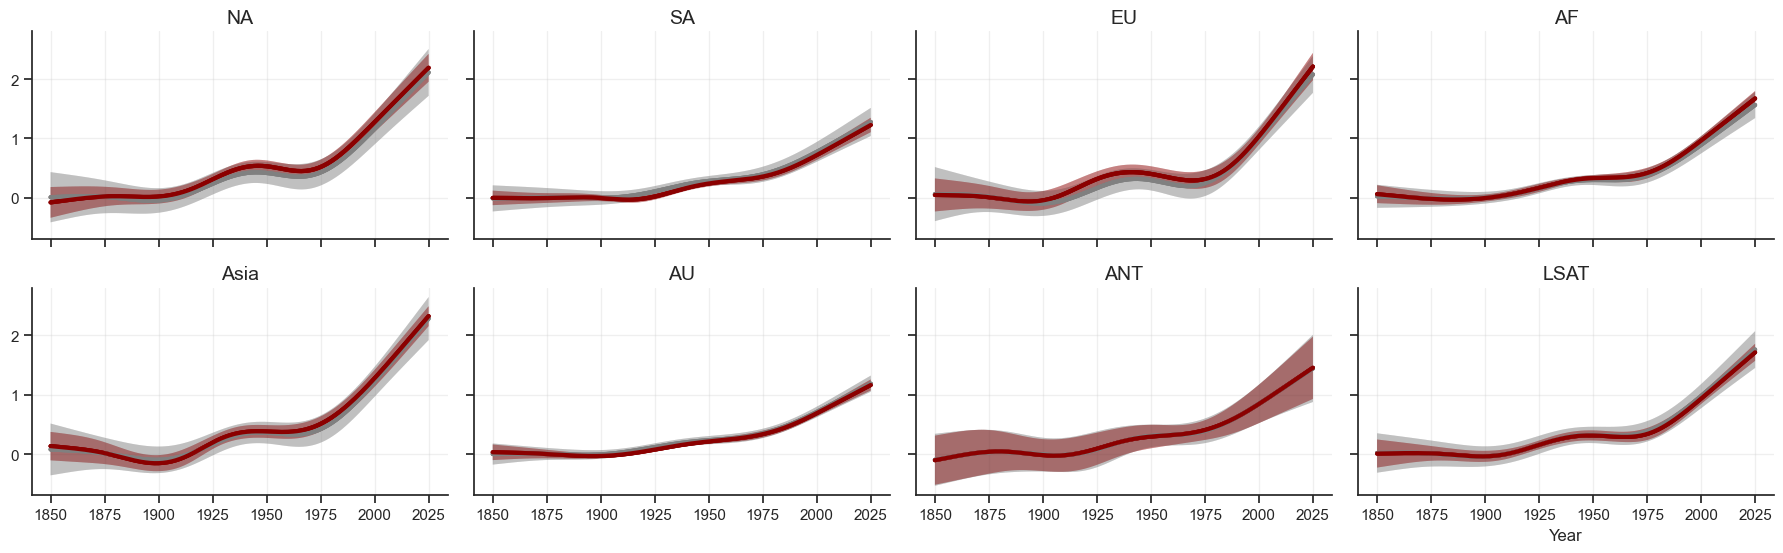

In [97]:
da1 = prior_post_smooth_forcing_5_adj_cont_glob_weighted.sel(
    forcing='ALL', scheme='post'
)

da2 = prior_post_smooth.assign_coords(region=prior_post_smooth['abbrevs']).sel(
    forcing='ALL', scheme='post'
)

regions = da1['region'].values
quantiles = da1['quantile'].values

fig, axes = plt.subplots(
    2,4, figsize=(18, 6),  # 8 panels
    sharex=True, sharey=True
)

axes = axes.flatten()

for i, reg in enumerate(regions):
    ax = axes[i]
    sub1 = da1.sel(region=reg)
    sub2 = da2.sel(region=reg)

    # Plot each quantile
    for q in quantiles:
        plot_line(ax, sub1.year, sub1.sel(quantile='mean'), color='gray', lw=3)
        plot_shading(ax, sub1.year, sub1.sel(quantile='5th'),sub1.sel(quantile='95th'), color='gray',alpha=.2)

        plot_line(ax, sub2.year, sub2.sel(quantile='mean'), color='darkred', lw=3)
        plot_shading(ax, sub2.year, sub2.sel(quantile='5th'),sub2.sel(quantile='95th'), color='darkred',alpha=.2)

        # ax.plot(sub.year, sub.sel(quantile=q), label=f"q{q}")

    ax.set_title(reg, fontsize=14)
    ax.grid(True, alpha=0.3)

# Common labels & legend
axes[-1].set_xlabel("Year")
# fig.text(0.04, 0.5, "Area-weighted warming (°C)", va='center', rotation='vertical')

# fig.legend(loc="lower center", ncol=3, fontsize=12)
fig.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()

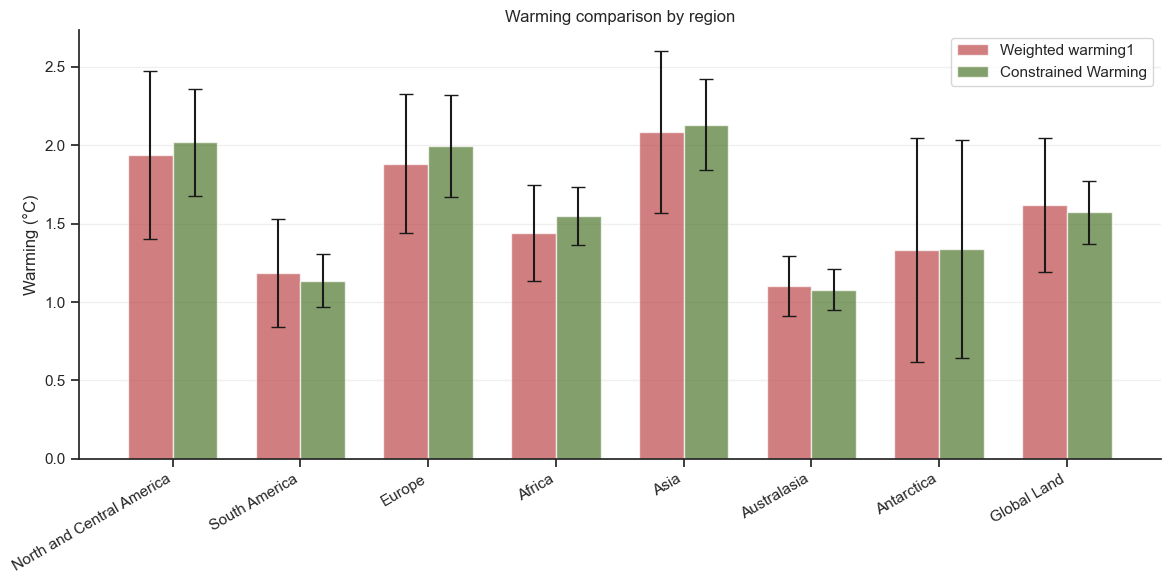

In [174]:
warming1 = prior_post_warm_forcing_5_adj_cont_glob_weighted.sel(forcing = 'ALL', scheme = 'post')
warming2 = prior_post_warm.sel(forcing = 'ALL', scheme = 'post').isel(region = slice(46,54)).assign_coords(region = warming1['region']) 

# Example data
da1 = warming1
da2 = warming2

regions = da1.names.values  # or da1.region.values
x = np.arange(len(regions))
width = 0.35  # bar width

# Compute central value and error
def get_values_and_error(da):
    mean = da.sel(quantile='mean').values
    err_low = mean - da.sel(quantile='5th').values
    err_high = da.sel(quantile='95th').values - mean
    err = np.vstack([err_low, err_high])
    return mean, err

mean1, err1 = get_values_and_error(da1)
mean2, err2 = get_values_and_error(da2)

# Create figure
fig, ax = plt.subplots(figsize=(12,6))

# Plot bars with error bars
ax.bar(x - width/2, mean1, width, yerr=err1, capsize=5, label='Weighted warming1', color='#bc4749', alpha=0.7)
ax.bar(x + width/2, mean2, width, yerr=err2, capsize=5, label='Constrained Warming', color='#4f772d', alpha=0.7)

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=30, ha='right')
ax.set_ylabel('Warming (°C)')
ax.set_title('Warming comparison by region')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [99]:
uncertainty_ref_period=(1850, 2025)
ref_period=(1850, 2025)
obs_adjust_ref_period=(1961, 2023)
warming_target_period=(2016, 2025)

In [167]:
def plot_forcing_panels(
    sel_forcing,
    regions,
    prior_smooth,
    post_smooth,
    obs_adjust,
    ref_period,
    ncols=8,
    figsize=(40, 20),
    ylim=(-2, 4)
):
    """
    Plot attributable warming time series for each region under a given forcing.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    n_panels = len(regions)
    nrows = (n_panels + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=300)
    axes = axes.flatten()

    sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

    for i, sel_region in enumerate(regions):
        ax = axes[i]

        # Select from Dataset
        prior = prior_post_smooth_new.sel(scheme = 'prior', region=prior_post_smooth_new['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')
        post = prior_post_smooth_new.sel(scheme = 'post', region=post_smooth['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')
        obs = obs_adjust.sel(region=obs_adjust['names'] == sel_region, forcing=sel_forcing).squeeze(dim='region')

        plot_line_shades(ax, prior, 'gray', 'Prior')
        plot_line_shades(ax, post, '#9b2226', 'Posterior')

        ax.scatter(obs['year'], obs, label='obs', zorder=3, s = 15)
        ax.set_title(sel_region)
        plot_res(ax, *ylim)

    # Hide unused axes
    for j in range(len(regions), len(axes)):
        fig.delaxes(axes[j])

    main_title = f"Attributable warming series to {sel_forcing} forcing\n(ref: {ref_period[0]}–{ref_period[1]})"
    fig.suptitle(main_title, fontsize=20, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

def plot_res(ax, ymin, ymax):

    ax.set_ylim(ymin, ymax)
    # plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # ax.set_ylabel('Temperature responses (°C)',fontsize = 18)  
    ax.legend(fontsize=12,  loc = 'upper left')

    # ax.set_title(title, loc='left', fontsize=20,
    #                 fontdict={'size': 'large', 'weight': 'bold'})

    plt.axhline(y=[0], c='gray', lw=3.0, alpha = 0.5, ls = 'dashed')



region_names = prior_warm_forcing_5_adj['names'].values
for sel_forcing in ['ALL']:
    plot_forcing_panels(
        sel_forcing,
        region_names,
        prior_smooth_forcing_5_adj.sel(forcing = ['ALL']),
        post_smooth_forcing_5_adj.sel(forcing = ['ALL']),
        obs_adj_ALL,
        ref_period
    )

In [169]:
prior_post_smooth_new

<xarray.DataArray 'prior_mean_5_95_smooth' (scheme: 2, region: 54, forcing: 5,
                                            year: 176, quantile: 3)> Size: 2MB
array([[[[[ 4.74563975e-02, -8.44869770e-01,  9.39782566e-01],
          [ 4.44591373e-02, -8.37243323e-01,  9.26161598e-01],
          [ 4.14619959e-02, -8.29617134e-01,  9.12541126e-01],
          ...,
          [ 2.36429759e+00,  5.71592241e-01,  4.15700293e+00],
          [ 2.40946295e+00,  5.75534047e-01,  4.24339185e+00],
          [ 2.45462831e+00,  5.79475854e-01,  4.32978076e+00]],

         [[-1.29749119e-01, -9.25347019e-01,  6.65848780e-01],
          [-1.21792641e-01, -9.15295895e-01,  6.71710613e-01],
          [-1.13836837e-01, -9.05249617e-01,  6.77575943e-01],
          ...,
          [ 1.86902595e+00, -1.86529159e-01,  3.92458105e+00],
          [ 1.90785704e+00, -2.03983760e-01,  4.01969785e+00],
          [ 1.94668432e+00, -2.21447191e-01,  4.11481583e+00]],

         [[ 4.58785491e-02, -2.48281592e-01,  3.40038690e-01],
          [ 4.30844561e-02, -2.60986767e-01,  3.47155679e-01],
          [ 4.02909436e-02, -2.73687671e-01,  3.54269558e-01],
          ...,
...
          [ 5.70102724e-02, -4.22725115e-02,  1.56293056e-01],
          [ 6.22610279e-02, -3.95906613e-02,  1.64112717e-01],
          [ 6.75117833e-02, -3.69127191e-02,  1.71936286e-01]],

         [[-6.85593049e-02, -3.33274305e-01,  1.96155696e-01],
          [-6.60999207e-02, -3.26493288e-01,  1.94293447e-01],
          [-6.36405788e-02, -3.19713210e-01,  1.92432052e-01],
          ...,
          [ 1.82420373e+00,  1.36567788e+00,  2.28272958e+00],
          [ 1.84715217e+00,  1.38004621e+00,  2.31425813e+00],
          [ 1.87010061e+00,  1.39441477e+00,  2.34578645e+00]],

         [[ 4.96828660e-02, -3.83089371e-01,  4.82455103e-01],
          [ 4.97767172e-02, -3.72789768e-01,  4.72343202e-01],
          [ 4.98705683e-02, -3.62490166e-01,  4.62231302e-01],
          ...,
          [-2.91089722e-01, -7.51953293e-01,  1.69773849e-01],
          [-2.86661772e-01, -7.54618050e-01,  1.81294506e-01],
          [-2.82233820e-01, -7.57282800e-01,  1.92815161e-01]]]]],
      shape=(2, 54, 5, 176, 3))
Coordinates:
  * region       (region) int64 432B 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * year         (year) int64 1kB 1850 1851 1852 1853 ... 2022 2023 2024 2025
  * forcing      (forcing) <U3 60B 'ALL' 'ANT' 'NAT' 'GHG' 'OA'
  * quantile     (quantile) <U4 48B 'mean' '5th' '95th'
    abbrevs      (region) <U4 864B 'GIC' 'NWN' 'NEN' 'WNA' ... 'AU' 'ANT' 'LSAT'
    names        (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'
    realization  int64 8B 100
  * scheme       (scheme) <U5 40B 'prior' 'post'

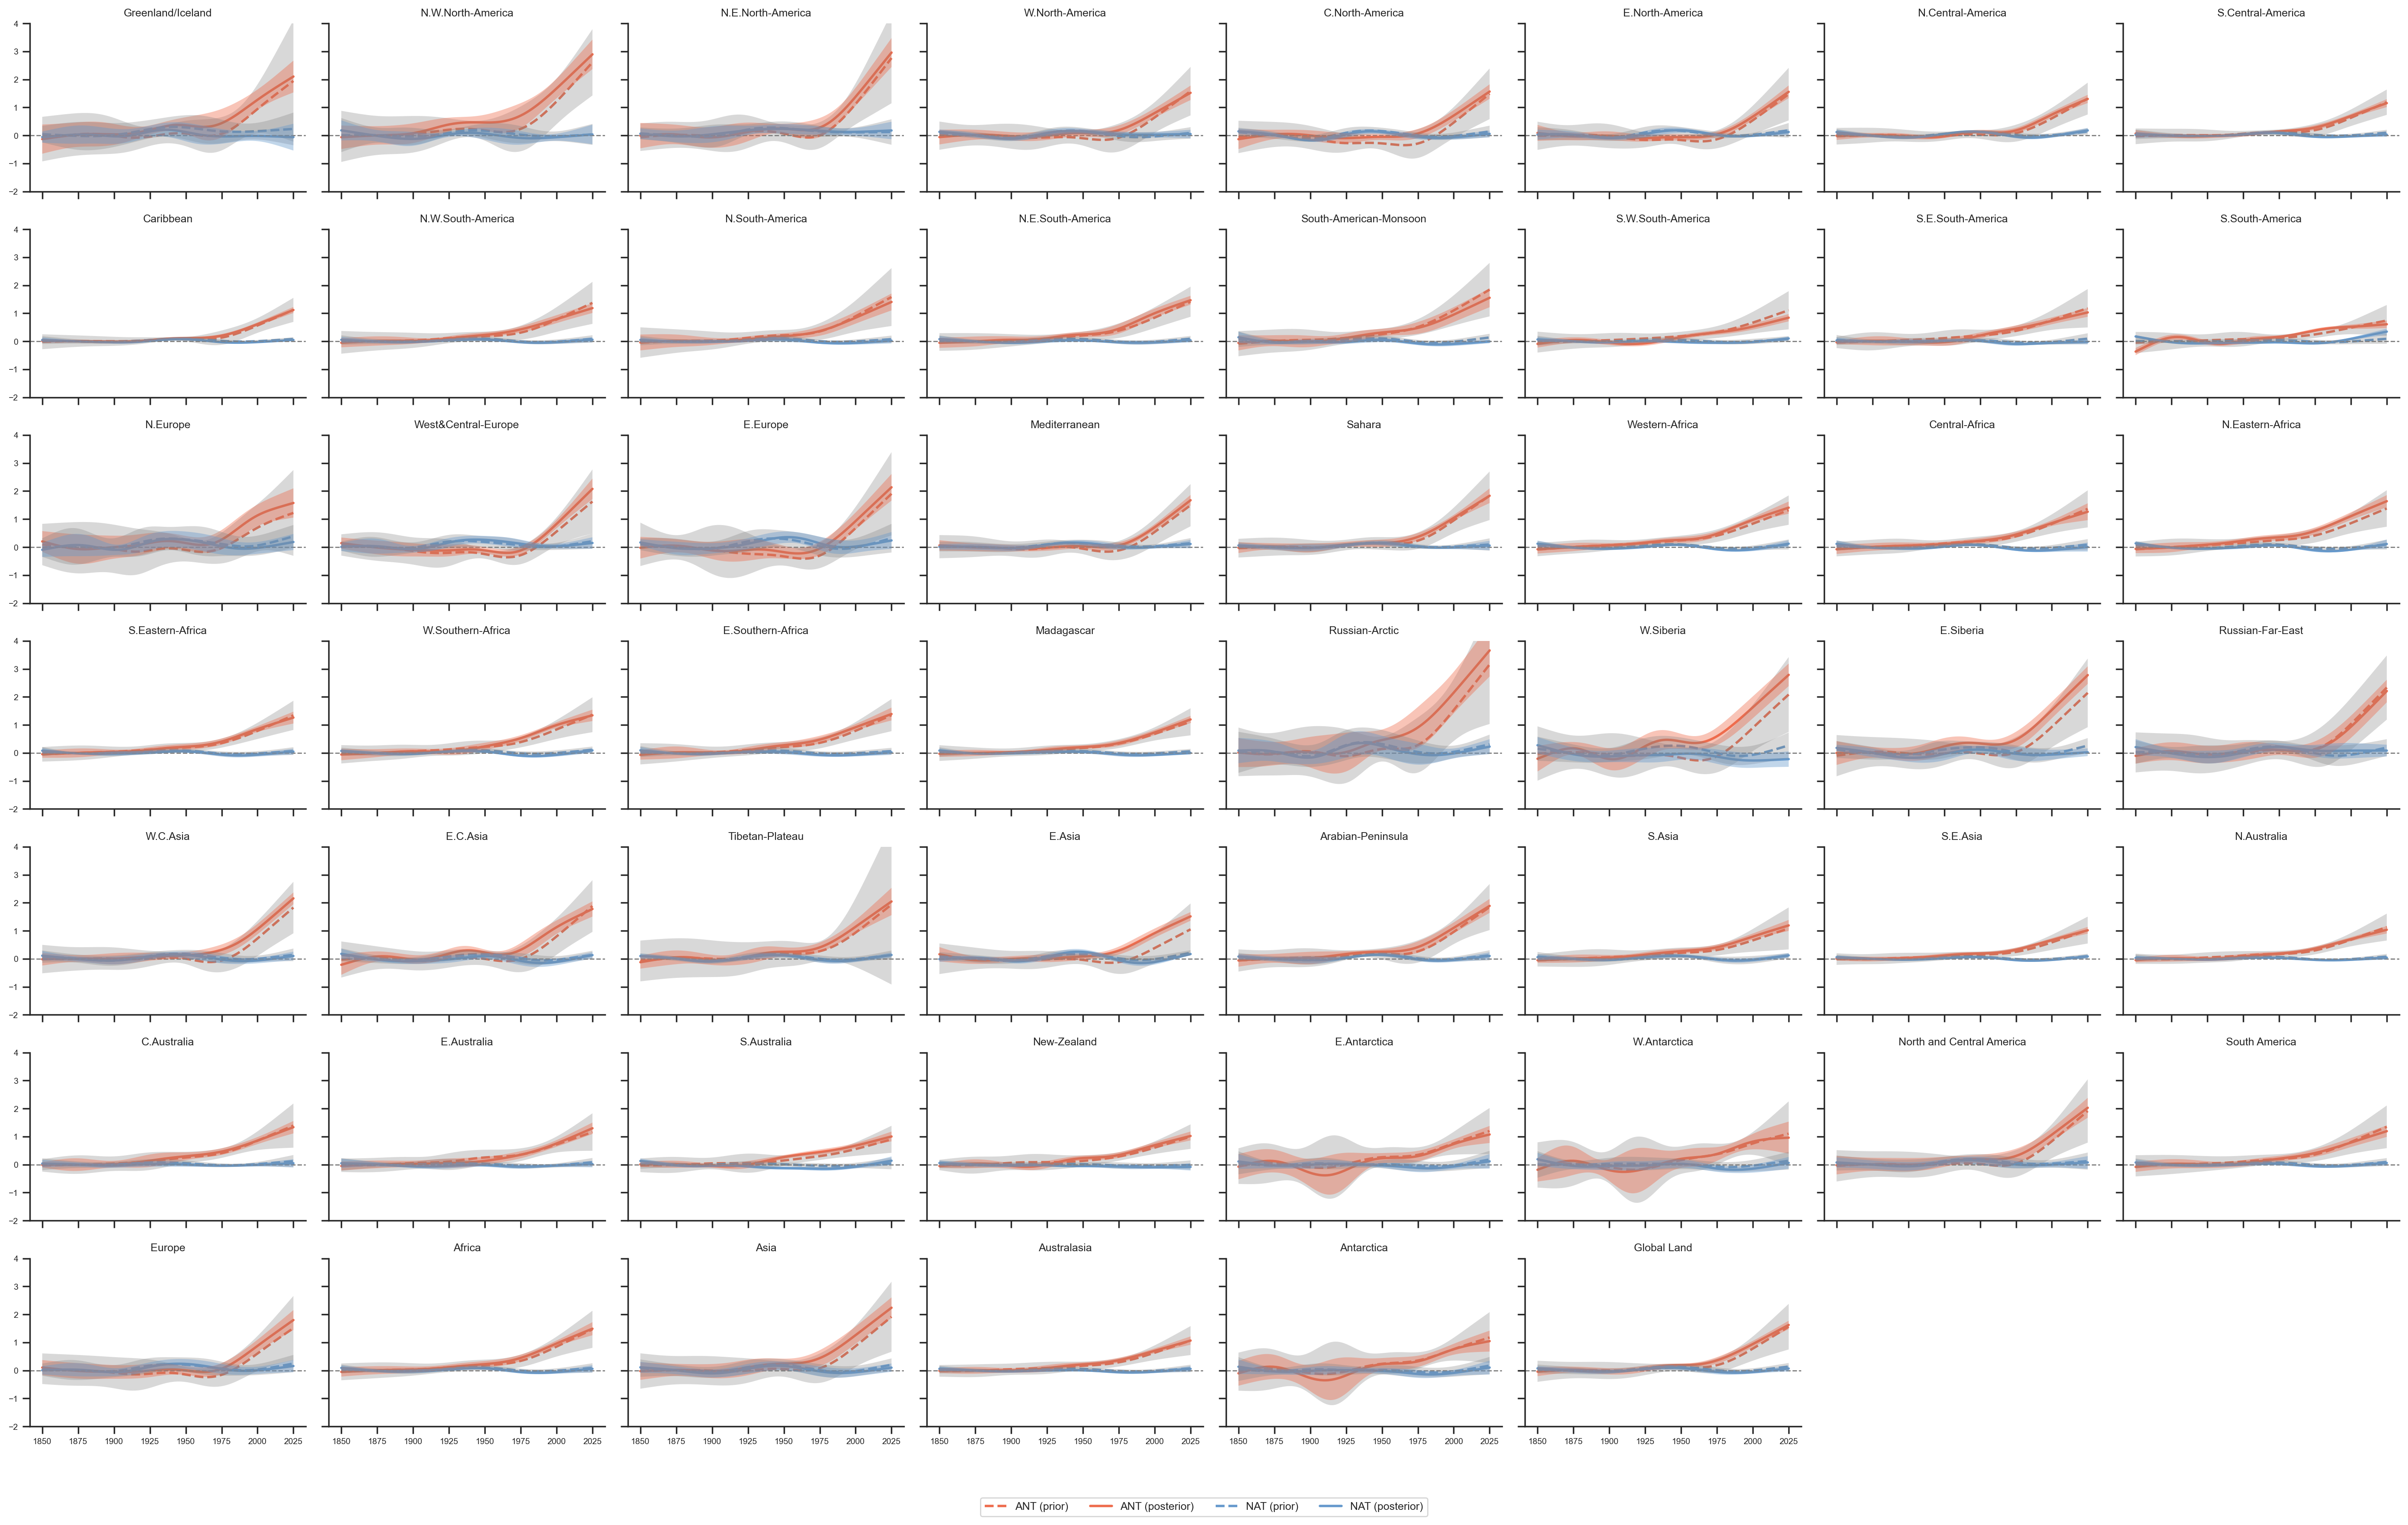

In [170]:
colors_forcings = ['#a23e48', '#ee6c4d', '#6699CC', '#F5CB5C', '#4C956C']  # 'ALL' 'ANT' 'NAT' 'GHG' 'OA'


# Parameters
nrows, ncols = 7, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 2.5 * nrows), dpi=200, sharex=True, sharey=True)
axes = axes.flatten()

# For collecting legend handles (only from first region)
legend_lines = []
legend_labels = []

for r_id, ax in enumerate(axes):
    if r_id >= len(region_names):
        ax.axis('off')
        continue

    data1 = prior_post_smooth_new.sel(scheme = 'prior')[r_id].sel(forcing=['ANT', 'NAT'])
    data2 = prior_post_smooth_new.sel(scheme = 'post')[r_id].sel(forcing=['ANT', 'NAT'])
    forcings1 = data1.forcing.values
    colors1 = ['#ee6c4d', '#6699CC']

    for i, forcing in enumerate(forcings1):
        # Individual
        line1, = ax.plot(data1['year'], data1.sel(quantile='mean')[i, :], linestyle='--', color=colors1[i], lw = 2)
        # Sum
        line2, = ax.plot(data2['year'], data2.sel(quantile='mean')[i, :], linestyle='-', color=colors1[i], lw = 2)
        
        # Shading
        plot_shading(ax, data1['year'], data1.sel(quantile='5th')[i, :], data1.sel(quantile='95th')[i, :], color='gray', alpha=0.3)
        plot_shading(ax, data2['year'], data2.sel(quantile='5th')[i, :], data2.sel(quantile='95th')[i, :], color=colors1[i], alpha=0.4)

        if r_id == 0:
            legend_lines.extend([line1, line2])
            legend_labels.extend([f'{forcing} (prior)', f'{forcing} (posterior)'])

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 4)
    ax.set_title(region_names[r_id], fontsize=9)
    ax.tick_params(labelsize=7)

# Add global legend below the plots
fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=4,
    fontsize=9
)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Leave space at bottom for legend
plt.show()

In [171]:
# Parameters
nrows, ncols = 7, 8
fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 2.5 * nrows), dpi=200, sharex=True, sharey=True)
axes = axes.flatten()

# For collecting legend handles (only from first region)
legend_lines = []
legend_labels = []

for r_id, ax in enumerate(axes):
    if r_id >= len(region_names):
        ax.axis('off')
        continue

    data1 = prior_post_smooth_new.sel(scheme = 'prior')[r_id]
    data2 = prior_post_smooth_new.sel(scheme = 'post')[r_id]
    forcings1 = data1.forcing.values

    for i, forcing in enumerate(forcings1):
        # Individual
        # line1, = ax.plot(data1['year'], data1.sel(quantile='mean')[i, :], linestyle='--', color=colors1[i])
        # Sum
        line2, = ax.plot(data2['year'], data2.sel(quantile='mean')[i, :], linestyle='-', color=colors_forcings[i], lw = 2)
        
        # Shading
        # plot_shading(ax, data1['year'], data1.sel(quantile='5th')[i, :], data1.sel(quantile='95th')[i, :], color='gray', alpha=0.2)
        plot_shading(ax, data2['year'], data2.sel(quantile='5th')[i, :], data2.sel(quantile='95th')[i, :], color=colors_forcings[i], alpha=0.3)

        if r_id == 0:
            legend_lines.extend([line2])
            legend_labels.extend([f'{forcing}'])

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 4)
    ax.set_title(region_names[r_id], fontsize=9)
    ax.tick_params(labelsize=7)

# Add global legend below the plots
fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=5,
    fontsize=9
)

plt.tight_layout(rect=[0, 0.03, 1, 1])  # Leave space at bottom for legend
plt.show()